In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [2]:
neg_path = load_path('train', 'n', 'neg', data = 'sm')
redspot_path = load_path('train', 'h', 'redspot', data = 'sm')
angio_path = load_path('train', 'h', 'angio', data = 'sm')
active_path = load_path('train', 'h', 'active', data = 'sm')
# ero_path = load_path('train', 'd', 'ero', data = 'sm')
# ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm')
# str_path = load_path('train', 'd', 'str', data = 'sm')

print("negative:",neg_path.shape)
print("red spot:",redspot_path.shape)
print("angioectasia:",angio_path.shape)
print("active_bleeding:",active_path.shape)
# print("erosion:",ero_path.shape)
# print("ulcer:",ulcer_path.shape)
# print("stricture:",str_path.shape)

negative: (49999,)
red spot: (4448,)
angioectasia: (147,)
active_bleeding: (3430,)


In [3]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
angio_train_path, angio_valid_path = train_valid_split(angio_path)
active_train_path, active_valid_path = train_valid_split(active_path)
# ero_train_path, ero_valid_path = train_valid_split(ero_path)
# ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
# str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
print("active bleeding:", active_train_path.shape, active_valid_path.shape)
# print("erosion:", ero_train_path.shape, ero_valid_path.shape)
# print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
# print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (42499,) (7500,)
red spot: (3781,) (667,)
angioectasia: (125,) (22,)
active bleeding: (2916,) (514,)


# Model

In [4]:
input_h = 512
input_w = 512
input_ch = 3

k1_ch = 16
# 256 256 16

k2_ch = 16
# 128 128 16

k3_ch = 16
# 64 64 16

k4_ch = 32
# 32 32 32

k5_ch = 32
# 16 16 32

k6_ch = 32
# 8 8 32

k7_ch = 64
# 4 4 64

n_hidden1 = 100
n_hidden2 = 50
n_output = 2

In [5]:
class CE_cnn:
    def __init__(self, k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output):
        self.k1_ch = k1_ch
        self.k2_ch = k2_ch
        self.k3_ch = k3_ch
        self.k4_ch = k4_ch
        self.k5_ch = k5_ch
        self.k6_ch = k6_ch
        self.k7_ch = k7_ch
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
    def conv_block(self, x, k_channel, maxp_name = 'maxp'):
        conv1 = tf.layers.conv2d(inputs = x, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs = conv1, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        maxp = tf.layers.max_pooling2d(inputs = conv2, 
                                       pool_size = [2, 2], 
                                       strides = 2,
                                       name = maxp_name)
        return maxp

    def fc2_layers(self, x, n_hidden1, n_hidden2, n_output, score_name = 'score'):
        maxp_re = tf.layers.flatten(x)
        hidden1 = tf.layers.dense(inputs = maxp_re, 
                                  units = n_hidden1,
                                  activation = tf.nn.relu)
        hidden1 = tf.layers.dropout(hidden1, rate = 0.3, training = is_training) # Drouout
        hidden2 = tf.layers.dense(inputs = hidden1, 
                                  units = n_hidden2,
                                  activation = tf.nn.relu)
        hidden2 = tf.layers.dropout(hidden2, rate = 0.3, training = is_training) # Drouout
        score = tf.layers.dense(inputs = hidden2, units = n_output, name = score_name)
        return score

    def inf(self, x):
        conv1 = self.conv_block(x, self.k1_ch, 'maxp1')
        conv2 = self.conv_block(conv1, self.k2_ch, 'maxp2')
        conv3 = self.conv_block(conv2, self.k3_ch, 'maxp3')
        conv4 = self.conv_block(conv3, self.k4_ch, 'maxp4')
        conv5 = self.conv_block(conv4, self.k5_ch, 'maxp5')
        conv6 = self.conv_block(conv5, self.k6_ch, 'maxp6')
        conv7 = self.conv_block(conv6, self.k7_ch, 'maxp7')

        score = self.fc2_layers(conv7, self.n_hidden1, self.n_hidden2, self.n_output, 'score')

        return score

In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
LR = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool, name = 'is_training')

model = CE_cnn(k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

W0111 17:22:43.987360 139828400477952 deprecation.py:323] From <ipython-input-5-249d499180cf>:18: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0111 17:22:43.991811 139828400477952 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0111 17:22:44.197431 139828400477952 deprecation.py:323] From <ipython-input-5-249d499180cf>:27: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0111 17:22:44.484737 139828400477952 deprecation.py:323] F

# Training

## N:H=3:7 batch-size and damaped exp LR and early stopping

damped_exp_LR(10000) <br>
total_batch = 100 <br>
cal_interval = 10 <br>
prt_interval = 100 <br>
early stopping = True <br>

In [7]:
h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

h_train_path = shuffle(h_train_path, None)
h_valid_path = shuffle(h_valid_path, None)

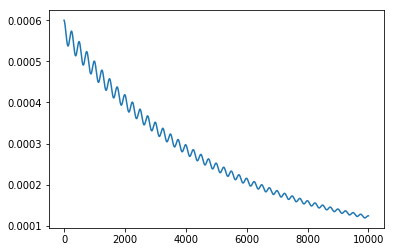

In [8]:
D_lr = damped_exp_LR(10000)

plt.plot(D_lr)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0111 17:25:22.267073 139828400477952 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 70.00 %    || 50.00 %    || 0.46193916 || 0.63316274
--------------------------------------------------------------
[*200] || 75.00 %    || 61.00 %    || 0.41446048 || 0.56675631
--------------------------------------------------------------
[*300] || 92.00 %    || 92.00 %    || 0.22102310 || 0.25912106
--------------------------------------------------------------
[*400] || 91.00 %    || 94.00 %    || 0.19935723 || 0.20901409
--------------------------------------------------------------
[*500] || 95.00 %    || 92.00 %    || 0.12272937 || 0.16461758
--------------------------------------------------------------
[*600] || 98.00 %    || 98.00 %    || 0.12430831 || 0.07152935
--------------------------------------------------------------
[*700] || 96.00 %    || 93.00 %    || 0.13334842 || 0.17163202
--------------------------------------------------------------
[*800] || 95.00 %    || 95.00 %    || 0.10899074 || 0.11317026
-------------------------------------------------------

[6600] || 99.00 %    || 92.00 %    || 0.02005844 || 0.51124740
--------------------------------------------------------------
[6700] || 100.00 %    || 99.00 %    || 0.00256585 || 0.03031108
--------------------------------------------------------------
[6800] || 100.00 %    || 99.00 %    || 0.00137568 || 0.04258584
--------------------------------------------------------------
[6900] || 100.00 %    || 97.00 %    || 0.00179249 || 0.08476564
--------------------------------------------------------------
[7000] || 100.00 %    || 96.00 %    || 0.00685383 || 0.17094751
--------------------------------------------------------------
[7100] || 100.00 %    || 97.00 %    || 0.00101484 || 0.07999893
--------------------------------------------------------------
[7200] || 100.00 %    || 99.00 %    || 0.00202214 || 0.07322954
--------------------------------------------------------------
[7300] || 100.00 %    || 95.00 %    || 0.00071703 || 0.15657562
------------------------------------------------

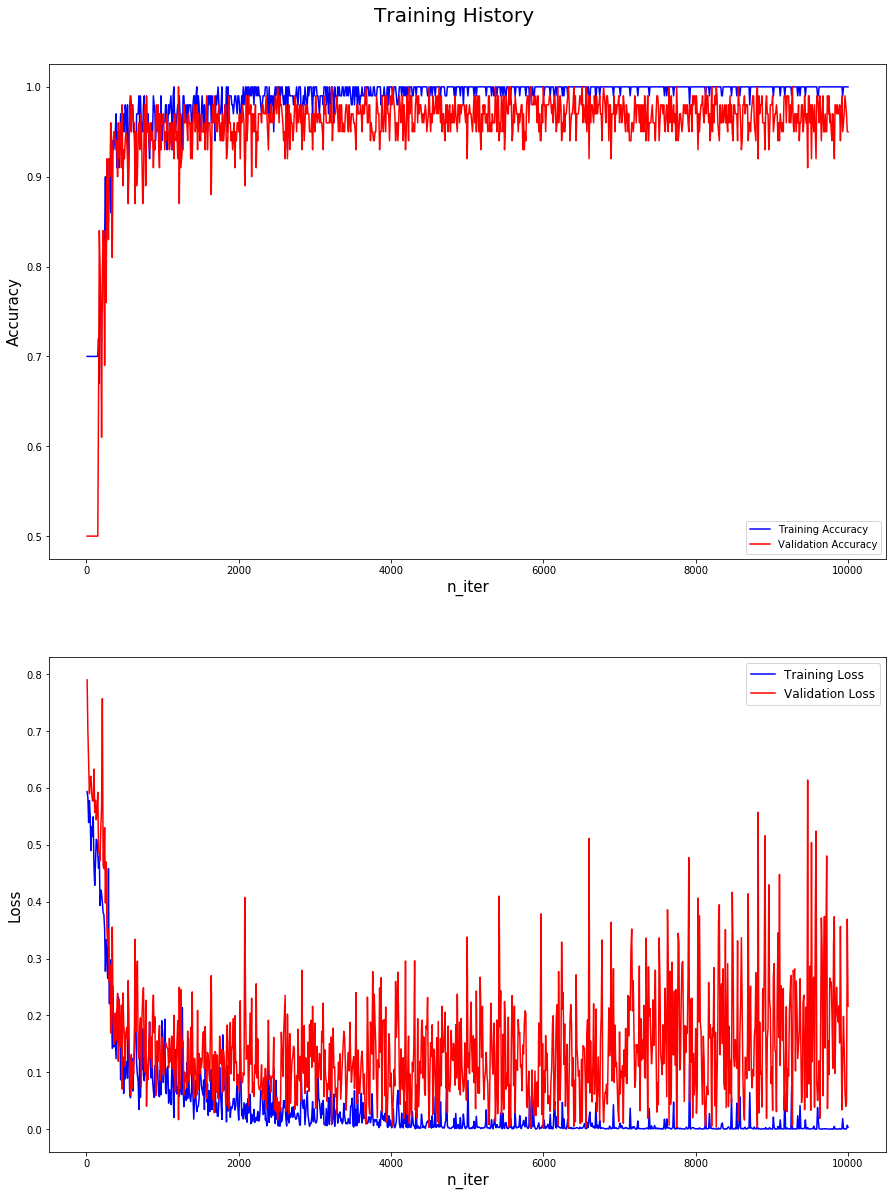

In [9]:
n_iter = 0
total_batch = 100
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    
    neg_batch = int(0.3*total_batch)
    h_batch = int(0.7*total_batch)
    
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = neg_batch)
    h_train_x, h_train_y = load_random_minibatch(h_train_path, cls = 1, batch_size = h_batch)
    train_x = np.vstack([neg_train_x, h_train_x])
    train_y = np.vstack([neg_train_y, h_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = int(total_batch/2))
        h_valid_x, h_valid_y = load_random_minibatch(h_valid_path, cls = 1, batch_size = int(total_batch/2))
        valid_x = np.vstack([neg_valid_x, h_valid_x])
        valid_y = np.vstack([neg_valid_y, h_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'N3H7_1_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 10000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## equal batch-size by class and damaped exp LR and early stopping

damped_exp_LR(10000) <br>
t_batch = 32 <br>
v_batch = 128 <br>
cal_interval = 10 <br>
prt_interval = 100 <br>
early stopping = True <br>

In [14]:
h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

h_train_path = shuffle(h_train_path, None)
h_valid_path = shuffle(h_valid_path, None)

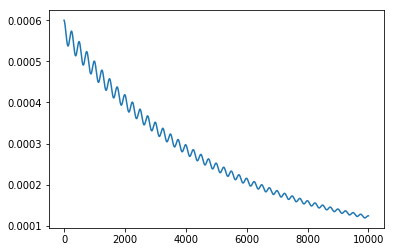

In [15]:
D_lr = damped_exp_LR(10000)

plt.plot(D_lr)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 70.00 %    || 73.00 %    || 0.54144597 || 0.53914106
--------------------------------------------------------------
[*200] || 78.00 %    || 77.00 %    || 0.47843453 || 0.45695356
--------------------------------------------------------------
[*300] || 78.00 %    || 72.00 %    || 0.45629191 || 0.50822628
--------------------------------------------------------------
[*400] || 77.00 %    || 84.00 %    || 0.43186080 || 0.37459362
--------------------------------------------------------------
[*500] || 74.00 %    || 76.00 %    || 0.45969728 || 0.43208426
--------------------------------------------------------------
[*600] || 82.00 %    || 77.00 %    || 0.39928541 || 0.43460214
--------------------------------------------------------------
[*700] || 93.00 %    || 84.00 %    || 0.20006441 || 0.35222185
--------------------------------------------------------------
[*800] || 93.00 %    || 89.00 %    || 0.16082165 || 0.2

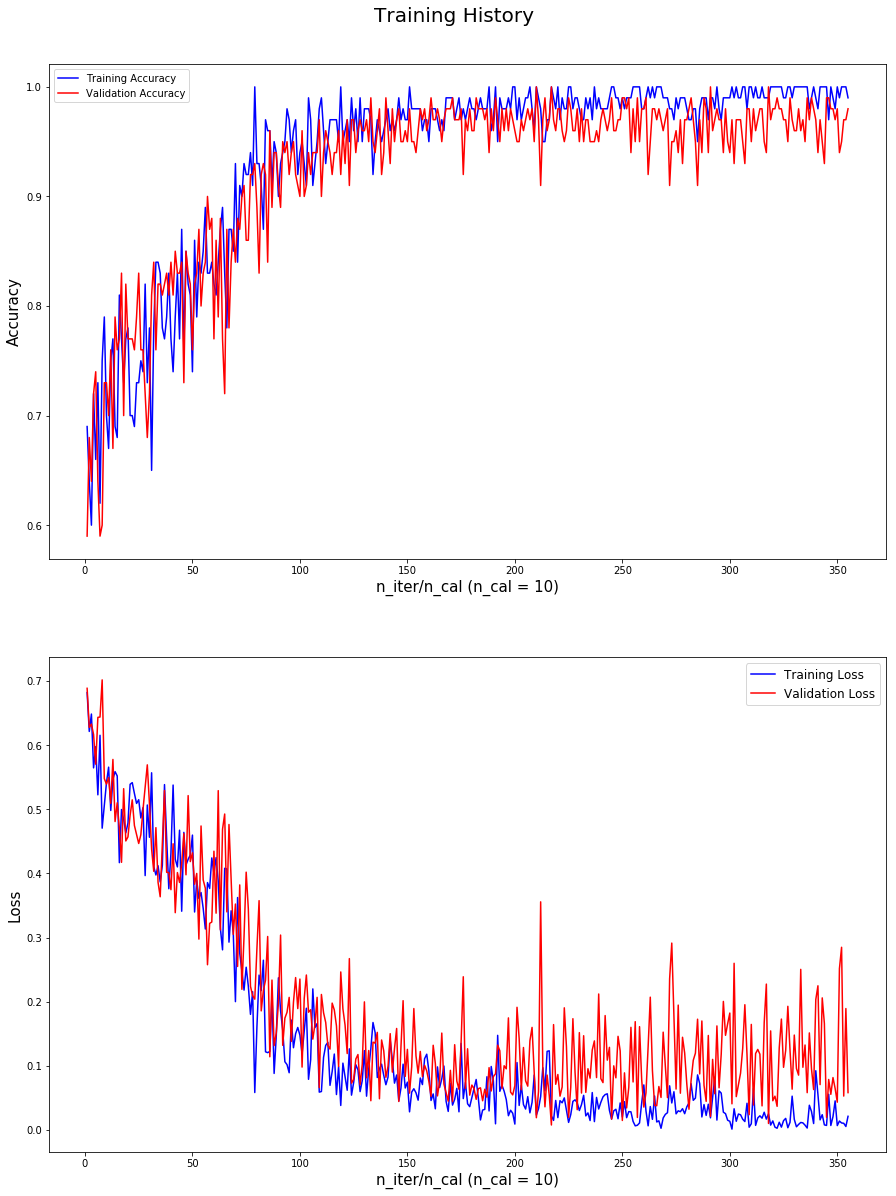

In [16]:
n_iter = 0
t_batch = 50
v_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    h_train_x, h_train_y = load_random_minibatch(h_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, h_train_x])
    train_y = np.vstack([neg_train_y, h_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        h_valid_x, h_valid_y = load_random_minibatch(h_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, h_valid_x])
        valid_y = np.vstack([neg_valid_y, h_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'NH_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
#         if n_iter == 20000:
#             break
        if n_iter > 2000:
            if np.max(accr_train) < 0.9:
                if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
                    hist.early_under(n_iter)
                    early_stopping = True
                    break
            if np.mean(accr_train[-50:]) >= 0.995:
                if (
                    np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
                    loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
                    ):
                    hist.early_over(n_iter)
                    early_stopping = True
                    break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## equal batch-size by class and damaped exp LR

damped_exp_LR(30000, alpha = 0.0001) <br>
t_batch = 30 <br>
v_batch = 120 <br>
cal_interval = 100 <br>
prt_interval = 100 <br>
early stopping = False <br>

In [7]:
h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

h_train_path = shuffle(h_train_path, None)
h_valid_path = shuffle(h_valid_path, None)

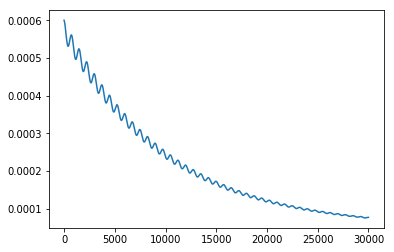

In [17]:
plt.plot(damped_exp_LR(30000, alpha = 0.0001))
D_lr = damped_exp_LR(30000, alpha = 0.0001)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 63.33 %    || 62.50 %    || 0.56245893 || 0.60559565
--------------------------------------------------------------
[*200] || 75.00 %    || 69.58 %    || 0.53935707 || 0.58009303
--------------------------------------------------------------
[*300] || 76.67 %    || 72.08 %    || 0.48572177 || 0.51765615
--------------------------------------------------------------
[*400] || 70.00 %    || 70.42 %    || 0.56896114 || 0.55555242
--------------------------------------------------------------
[*500] || 81.67 %    || 72.50 %    || 0.50447947 || 0.55989957
--------------------------------------------------------------
[*600] || 81.67 %    || 77.50 %    || 0.42659494 || 0.49726760
--------------------------------------------------------------
[*700] || 83.33 %    || 82.08 %    || 0.39388826 || 0.48004290
--------------------------------------------------------------


W0108 15:48:13.995892 140651479295744 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*800] || 85.00 %    || 85.42 %    || 0.35946724 || 0.37836367
--------------------------------------------------------------
[*900] || 86.67 %    || 91.67 %    || 0.27115002 || 0.27206102
--------------------------------------------------------------
[1000] || 90.00 %    || 86.67 %    || 0.17957963 || 0.29251105
--------------------------------------------------------------
[1100] || 95.00 %    || 92.50 %    || 0.18785782 || 0.20418555
--------------------------------------------------------------
[1200] || 98.33 %    || 96.67 %    || 0.05036705 || 0.10686299
--------------------------------------------------------------
[1300] || 90.00 %    || 94.17 %    || 0.21620955 || 0.17679228
--------------------------------------------------------------
[1400] || 95.00 %    || 95.00 %    || 0.16295290 || 0.14012460
--------------------------------------------------------------
[1500] || 93.33 %    || 93.33 %    || 0.19741711 || 0.18360554
-------------------------------------------------------

[7300] || 100.00 %    || 95.00 %    || 0.00730325 || 0.15748762
--------------------------------------------------------------
[7400] || 100.00 %    || 96.67 %    || 0.01144575 || 0.10462589
--------------------------------------------------------------
[7500] || 96.67 %    || 94.58 %    || 0.06191532 || 0.13579823
--------------------------------------------------------------
[7600] || 100.00 %    || 96.25 %    || 0.01210275 || 0.16705298
--------------------------------------------------------------
[7700] || 100.00 %    || 97.08 %    || 0.01065998 || 0.06360704
--------------------------------------------------------------
[7800] || 100.00 %    || 97.08 %    || 0.00129949 || 0.10863474
--------------------------------------------------------------
[7900] || 100.00 %    || 95.83 %    || 0.00813580 || 0.20906286
--------------------------------------------------------------
[8000] || 98.33 %    || 96.67 %    || 0.07765713 || 0.12710671
-------------------------------------------------

[13800] || 100.00 %    || 97.08 %    || 0.00043177 || 0.19845690
--------------------------------------------------------------
[13900] || 100.00 %    || 94.58 %    || 0.00025126 || 0.21261527
--------------------------------------------------------------
[14000] || 100.00 %    || 96.67 %    || 0.00175870 || 0.22948250
--------------------------------------------------------------
[14100] || 100.00 %    || 97.50 %    || 0.00163346 || 0.08275325
--------------------------------------------------------------
[14200] || 100.00 %    || 96.25 %    || 0.00077035 || 0.30575851
--------------------------------------------------------------
[14300] || 100.00 %    || 94.58 %    || 0.00026204 || 0.33968458
--------------------------------------------------------------
[14400] || 100.00 %    || 97.92 %    || 0.01100755 || 0.11455458
--------------------------------------------------------------
[14500] || 100.00 %    || 94.17 %    || 0.00028190 || 0.29744801
---------------------------------------

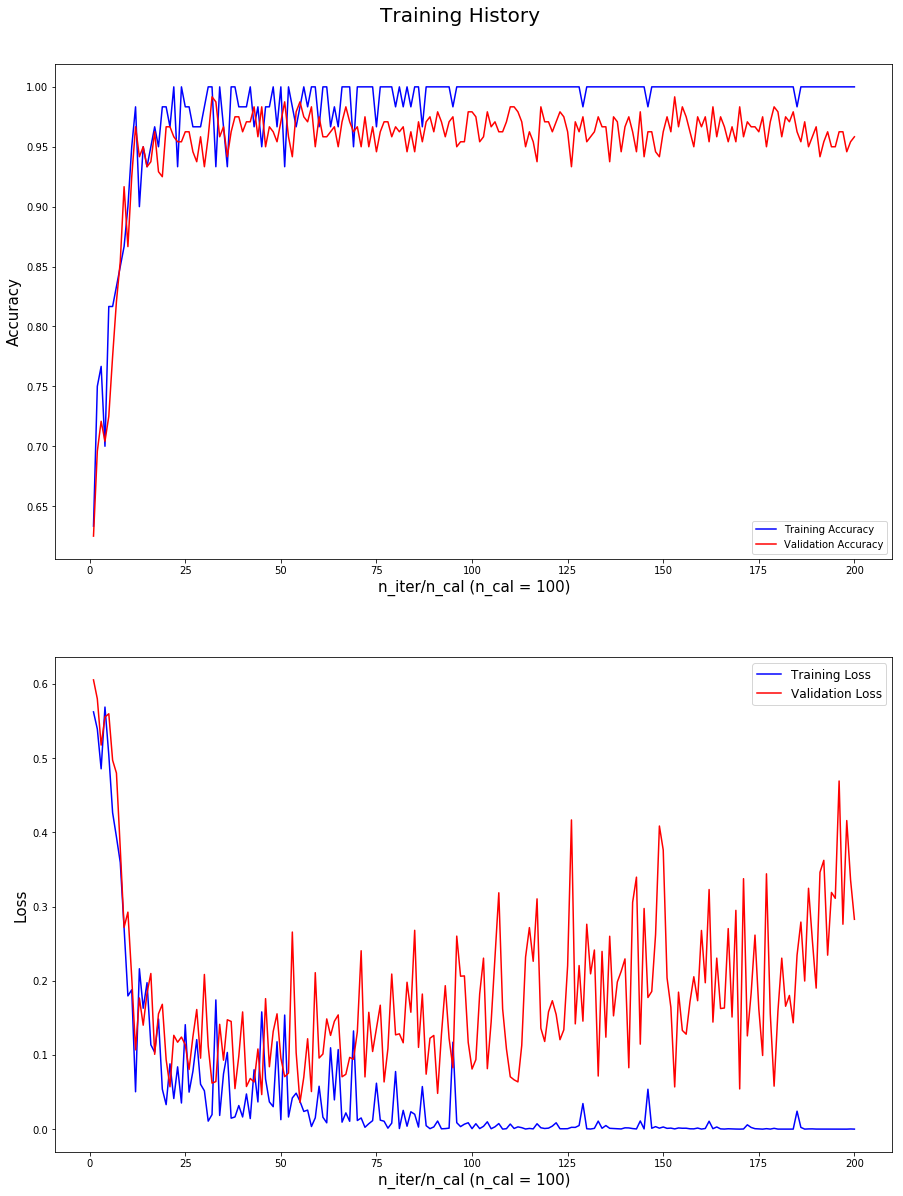

In [21]:
n_iter = 0
t_batch = 30
v_batch = 120
cal_interval = 100
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    h_train_x, h_train_y = load_random_minibatch(h_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, h_train_x])
    train_y = np.vstack([neg_train_y, h_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        h_valid_x, h_valid_y = load_random_minibatch(h_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, h_valid_x])
        valid_y = np.vstack([neg_valid_y, h_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'NH_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## equal batch-size by class and eqaul batch-size by lesion 

lr = 1e-4 --> lr *= 0.99999 <br>
t_batch = 30 <br>
v_batch = 120 <br>
    - lesion_batch = t_batch(v_batch)/3
cal_interval = 100 <br>
prt_interval = 1000 <br>
early stopping = False <br>

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[1000] || 93.33 %    || 89.17 %    || 0.22746158 || 0.26330933
--------------------------------------------------------------
[2000] || 91.67 %    || 95.42 %    || 0.21666910 || 0.12735304
--------------------------------------------------------------
[3000] || 100.00 %    || 93.33 %    || 0.03799279 || 0.12456364
--------------------------------------------------------------
[4000] || 96.67 %    || 93.75 %    || 0.07080165 || 0.18996389
--------------------------------------------------------------
[5000] || 98.33 %    || 96.67 %    || 0.02358383 || 0.11578328
--------------------------------------------------------------
[6000] || 96.67 %    || 97.08 %    || 0.11574171 || 0.06742322
--------------------------------------------------------------
[7000] || 100.00 %    || 97.08 %    || 0.01048282 || 0.05614000
--------------------------------------------------------------
[8000] || 100.00 %    || 99.17 %    || 0.01191300 || 

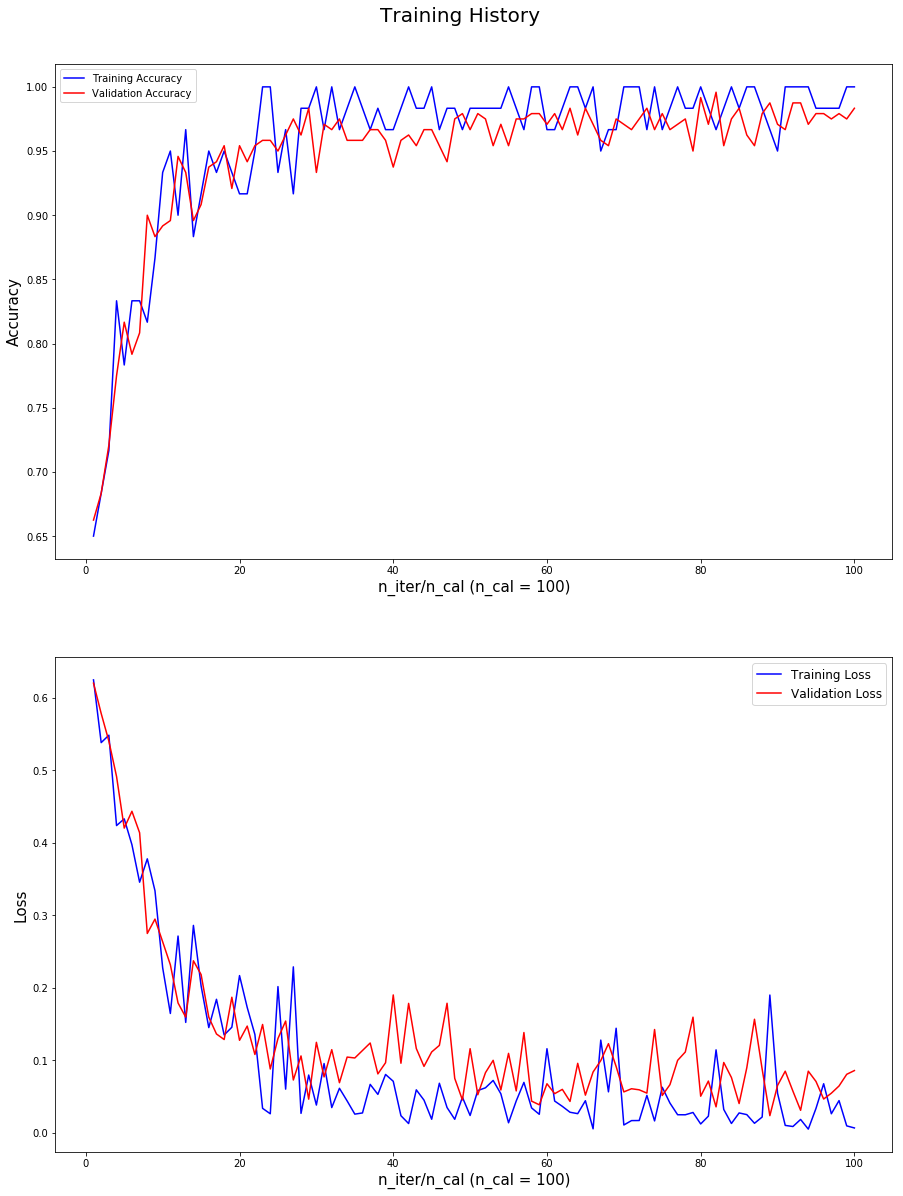

In [13]:
## test결과 - 각 병변별로 batch 수를 동일하게 불러오다보니 n수가 많은 병변을 더 잘 못 보는 느낌 ?

lr = 1e-4
n_iter = 0
t_batch = 30
v_batch = 120
cal_interval = 100
prt_interval = 1000
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    redspot_train_x, redspot_train_y = load_random_minibatch(redspot_train_path, cls = 1, batch_size = int(t_batch/3))
    angio_train_x, angio_train_y = load_random_minibatch(angio_train_path, cls = 1, batch_size = int(t_batch/3))
    active_train_x, active_train_y = load_random_minibatch(active_train_path, cls = 1, batch_size = int(t_batch/3))
    train_x = np.vstack([neg_train_x, redspot_train_x, angio_train_x, active_train_x])
    train_y = np.vstack([neg_train_y, redspot_train_y, angio_train_y, active_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        redspot_valid_x, redspot_valid_y = load_random_minibatch(redspot_valid_path, cls = 1, batch_size = int(v_batch/3))
        angio_valid_x, angio_valid_y = load_random_minibatch(angio_valid_path, cls = 1, batch_size = int(v_batch/3))
        active_valid_x, active_valid_y = load_random_minibatch(active_valid_path, cls = 1, batch_size = int(v_batch/3))
        valid_x = np.vstack([neg_valid_x, redspot_valid_x, angio_valid_x, active_valid_x])
        valid_y = np.vstack([neg_valid_y, redspot_valid_y, angio_valid_y, active_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'NH_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 10000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[11000] || 98.33 %    || 98.75 %    || 0.03437470 || 0.07212864
--------------------------------------------------------------
[12000] || 98.33 %    || 97.50 %    || 0.04468158 || 0.05699492
--------------------------------------------------------------
[13000] || 100.00 %    || 98.75 %    || 0.00022064 || 0.03144503
--------------------------------------------------------------
[14000] || 98.33 %    || 98.75 %    || 0.01779202 || 0.05072187
--------------------------------------------------------------
[15000] || 98.33 %    || 98.33 %    || 0.03800859 || 0.08652034
--------------------------------------------------------------
[16000] || 100.00 %    || 96.67 %    || 0.00100259 || 0.13205338
--------------------------------------------------------------
[17000] || 100.00 %    || 98.75 %    || 0.00478494 || 0.05550514
--------------------------------------------------------------
[18000] || 100.00 %    || 98.75 %    || 0.004

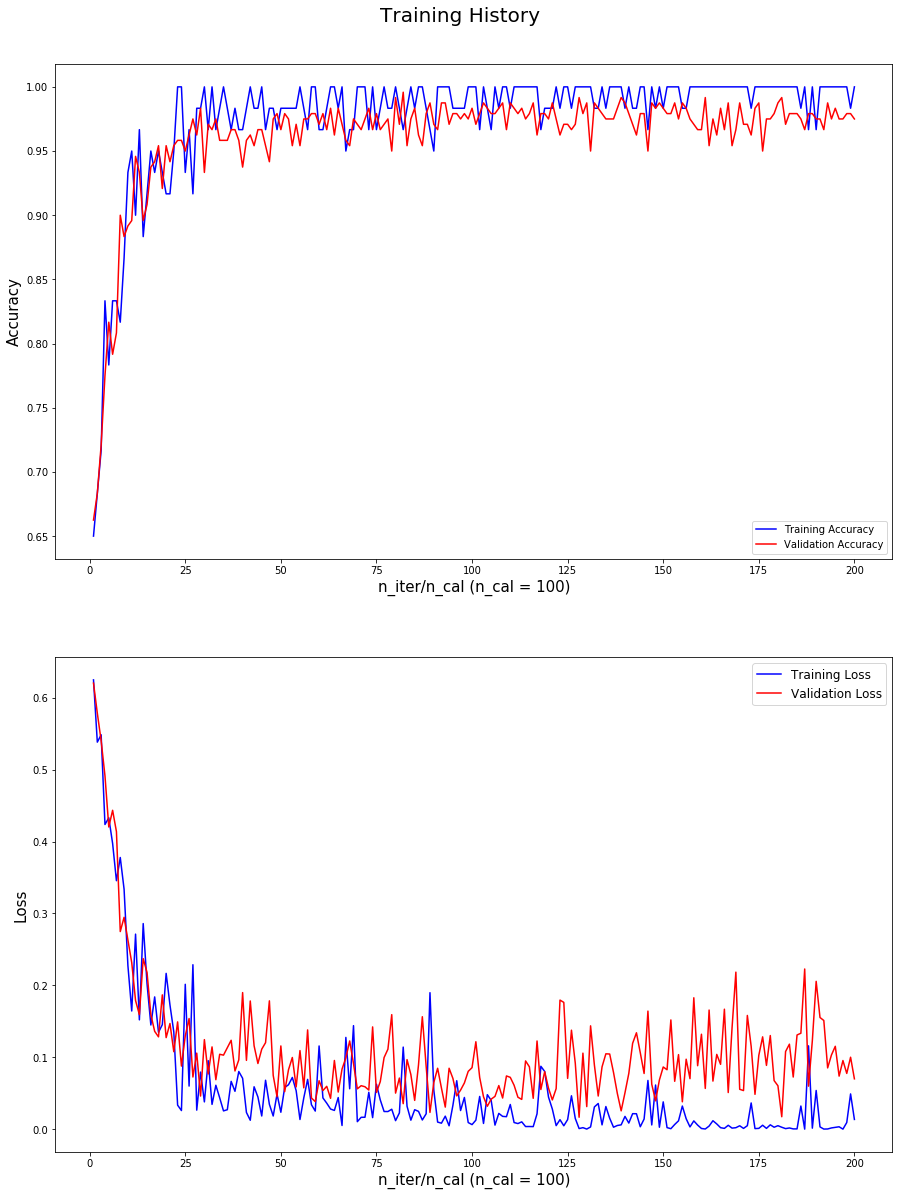

In [15]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    redspot_train_x, redspot_train_y = load_random_minibatch(redspot_train_path, cls = 1, batch_size = int(t_batch/3))
    angio_train_x, angio_train_y = load_random_minibatch(angio_train_path, cls = 1, batch_size = int(t_batch/3))
    active_train_x, active_train_y = load_random_minibatch(active_train_path, cls = 1, batch_size = int(t_batch/3))
    train_x = np.vstack([neg_train_x, redspot_train_x, angio_train_x, active_train_x])
    train_y = np.vstack([neg_train_y, redspot_train_y, angio_train_y, active_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        redspot_valid_x, redspot_valid_y = load_random_minibatch(redspot_valid_path, cls = 1, batch_size = int(v_batch/3))
        angio_valid_x, angio_valid_y = load_random_minibatch(angio_valid_path, cls = 1, batch_size = int(v_batch/3))
        active_valid_x, active_valid_y = load_random_minibatch(active_valid_path, cls = 1, batch_size = int(v_batch/3))
        valid_x = np.vstack([neg_valid_x, redspot_valid_x, angio_valid_x, active_valid_x])
        valid_y = np.vstack([neg_valid_y, redspot_valid_y, angio_valid_y, active_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'NH_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

In [16]:
from sklearn.svm import SVR

In [ ]:
train_poly = SVR(kernel = 'poly', degree = 3, gamma='auto', max_iter = -1, tol=0.1, verbose = True)
valid_poly = SVR(kernel = 'poly', degree = 3, gamma='auto', max_iter = -1, tol=0.1, verbose = True)
train_poly.fit(np.arange(len(accr_train)).reshape(-1,1), accr_train)
valid_poly.fit(np.arange(len(accr_valid)).reshape(-1,1), accr_valid)

[LibSVM]

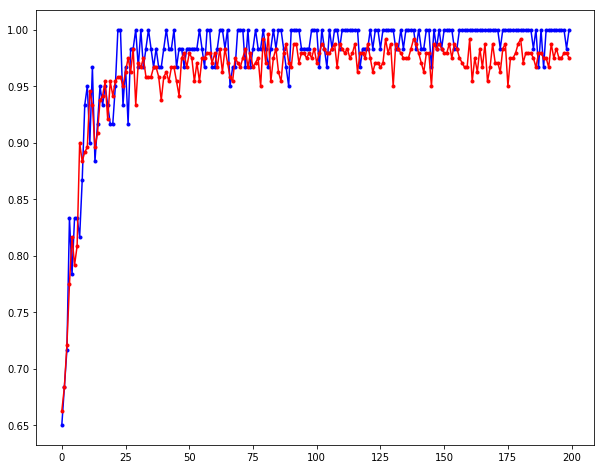

In [29]:
xp = np.arange(0, len(accr_train), 0.01).reshape(-1, 1)

plt.figure(figsize = (10, 8))
plt.plot(accr_train, 'b.-')
plt.plot(accr_valid, 'r.-')
# plt.plot(xp, train_poly.predict(xp), 'b--')
# plt.plot(xp, valid_poly.predict(xp), 'r--')
plt.show()

In [8]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    redspot_train_x, redspot_train_y = load_random_minibatch(redspot_train_path, cls = 1, batch_size = int(n_batch/3))
    angio_train_x, angio_train_y = load_random_minibatch(angio_train_path, cls = 1, batch_size = int(n_batch/3))
    active_train_x, active_train_y = load_random_minibatch(active_train_path, cls = 1, batch_size = int(n_batch/3))
    train_x = np.vstack([neg_train_x, redspot_train_x, angio_train_x, active_train_x])
    train_y = np.vstack([neg_train_y, redspot_train_y, angio_train_y, active_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        redspot_valid_x, redspot_valid_y = load_random_minibatch(redspot_valid_path, cls = 1, batch_size = int(n_batch/3))
        angio_valid_x, angio_valid_y = load_random_minibatch(angio_valid_path, cls = 1, batch_size = int(n_batch/3))
        active_valid_x, active_valid_y = load_random_minibatch(active_valid_path, cls = 1, batch_size = int(n_batch/3))
        valid_x = np.vstack([neg_valid_x, redspot_valid_x, angio_valid_x, active_valid_x])
        valid_y = np.vstack([neg_valid_y, redspot_valid_y, angio_valid_y, active_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'NH_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 10000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval) 

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[10100] || 98.33 %    || 100.00 %    || 0.03849171 || 0.02262043
--------------------------------------------------------------
[10200] || 98.33 %    || 96.67 %    || 0.02449408 || 0.04597896
--------------------------------------------------------------
[10300] || 98.33 %    || 98.33 %    || 0.05307697 || 0.11486893
--------------------------------------------------------------
[10400] || 100.00 %    || 98.33 %    || 0.00590207 || 0.03413134
--------------------------------------------------------------
[10500] || 100.00 %    || 100.00 %    || 0.01087974 || 0.01434399
--------------------------------------------------------------
[10600] || 98.33 %    || 98.33 %    || 0.03666603 || 0.07987682
--------------------------------------------------------------
[10700] || 98.33 %    || 95.00 %    || 0.02255248 || 0.08248110
--------------------------------------------------------------
[10800] || 100.00 %    || 96.67 %    || 0.01

[16400] || 100.00 %    || 95.00 %    || 0.00100575 || 0.32491300
--------------------------------------------------------------
[16500] || 100.00 %    || 91.67 %    || 0.00023429 || 0.46542436
--------------------------------------------------------------
[16600] || 100.00 %    || 95.00 %    || 0.02117553 || 0.17252101
--------------------------------------------------------------
[16700] || 100.00 %    || 98.33 %    || 0.00926678 || 0.10688908
--------------------------------------------------------------
[16800] || 100.00 %    || 96.67 %    || 0.00344610 || 0.11497791
--------------------------------------------------------------
[16900] || 100.00 %    || 96.67 %    || 0.00176567 || 0.15218601
--------------------------------------------------------------
[17000] || 100.00 %    || 100.00 %    || 0.01631036 || 0.01299508
--------------------------------------------------------------
[17100] || 100.00 %    || 98.33 %    || 0.00679821 || 0.24545075
--------------------------------------

[22800] || 100.00 %    || 98.33 %    || 0.01271708 || 0.16569491
--------------------------------------------------------------
[22900] || 100.00 %    || 98.33 %    || 0.00160855 || 0.07095087
--------------------------------------------------------------
[23000] || 100.00 %    || 98.33 %    || 0.00083321 || 0.19982094
--------------------------------------------------------------
[23100] || 100.00 %    || 98.33 %    || 0.00033779 || 0.10645167
--------------------------------------------------------------
[23200] || 100.00 %    || 93.33 %    || 0.00586109 || 0.35291073
--------------------------------------------------------------
[23300] || 100.00 %    || 100.00 %    || 0.00012079 || 0.00197031
--------------------------------------------------------------
[23400] || 100.00 %    || 100.00 %    || 0.00012390 || 0.00213597
--------------------------------------------------------------
[23500] || 100.00 %    || 98.33 %    || 0.00000851 || 0.30381930
-------------------------------------

KeyboardInterrupt: 

Training Time : 111 Min.
Early Stopping : False
Iteration : 24984



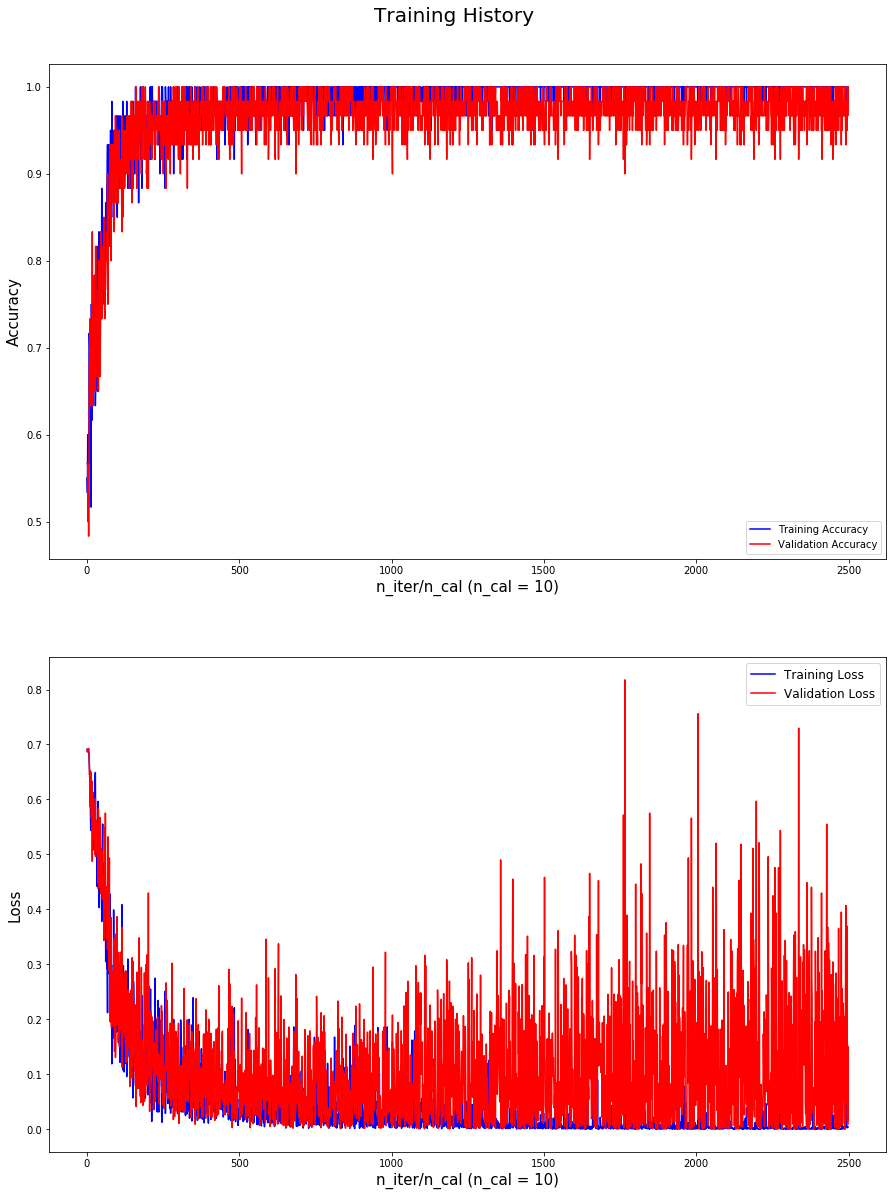

In [9]:
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval) 